In [2]:
import pickle
import os.path
from collections import OrderedDict

from models.Song import ComparableSong
from utils.utils import Utils

utils = Utils()

if not (os.path.exists(os.path.join("data", "output", "songs.out")) 
        and os.path.exists(os.path.join("data", "output", "duplicates.out"))):
    
    # Generate files
    import main
    main.main()
songs = pickle.load(open(os.path.join("data", "output", "songs.out"), "rb"))

duplicates = pickle.load(open(os.path.join("data", "output", "duplicates.out"), "rb"))
server_ids = utils.get_server_ids()


class Server:
    def __init__(self, uid):
        self.uid = uid
        self.index_times = 0
        self.first_place = 0
    
    @property
    def relative_score(self):
        if self.index_times:
            return self.first_place/self.index_times
        return 0
    
    def add_first_place(self):
        self.first_place += 1
        
    def add_index(self):
        self.index_times += 1

servers = {uid: Server(uid) for uid in server_ids}

# Make scores

scoring_table = []
for duplicate_songs in duplicates:
    temp = OrderedDict()
    all_servers = []  # for easier searching
    for comparable_song in duplicate_songs:
        temp.setdefault(comparable_song.song.bit_rate, []).append(comparable_song.song.server)
        all_servers.append(comparable_song.song.server)
    temp["all"] = all_servers
    scoring_table.append(temp)

for sample in scoring_table:
    sample = sample  # type: OrderedDict
    keys = list(sample.keys())
    for server_uid in sample[keys[0]]:
        servers[server_uid].add_first_place()
    for server_uid in sample["all"]:
        servers[server_uid].add_index()

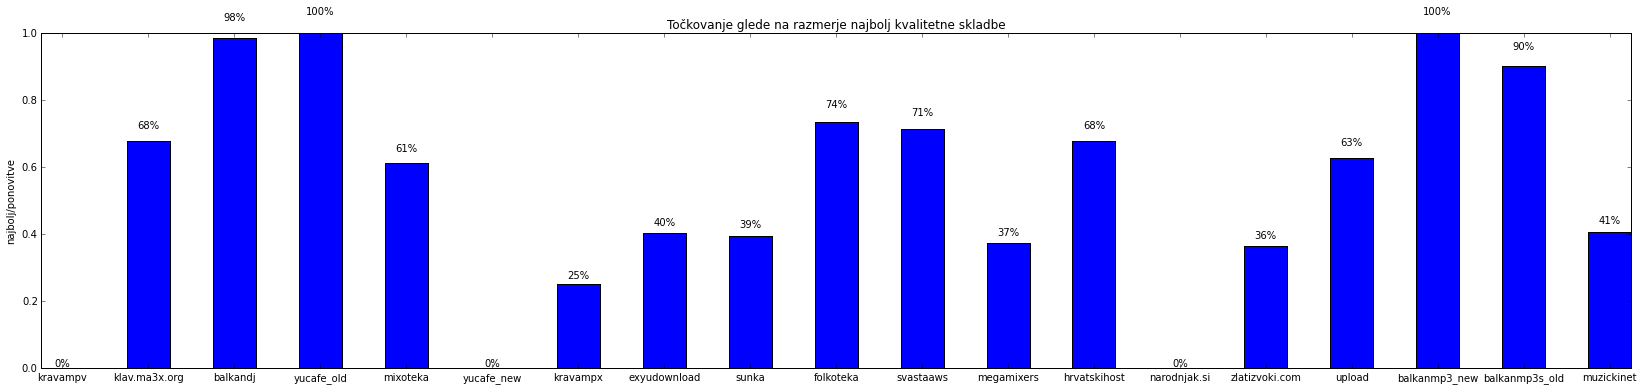

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

server_dict = utils.get_server_dict()
server_ids = utils.get_server_ids()

plt.rcParams["figure.figsize"] = (len(servers)*1.5, 6)

width = 0.5

fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(servers)) + width/2)
ax.set_xticklabels(list(server_dict[s] for s in server_ids))

ax.set_ylabel('najbolj/ponovitve')
ax.set_title('Točkovanje glede na razmerje najbolj kvalitetne skladbe')

for rect in ax.bar(range(len(servers)), [servers[k].relative_score for k in servers], color="blue", width=width):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{:.0%}'.format(height),
                ha="center", va="bottom")

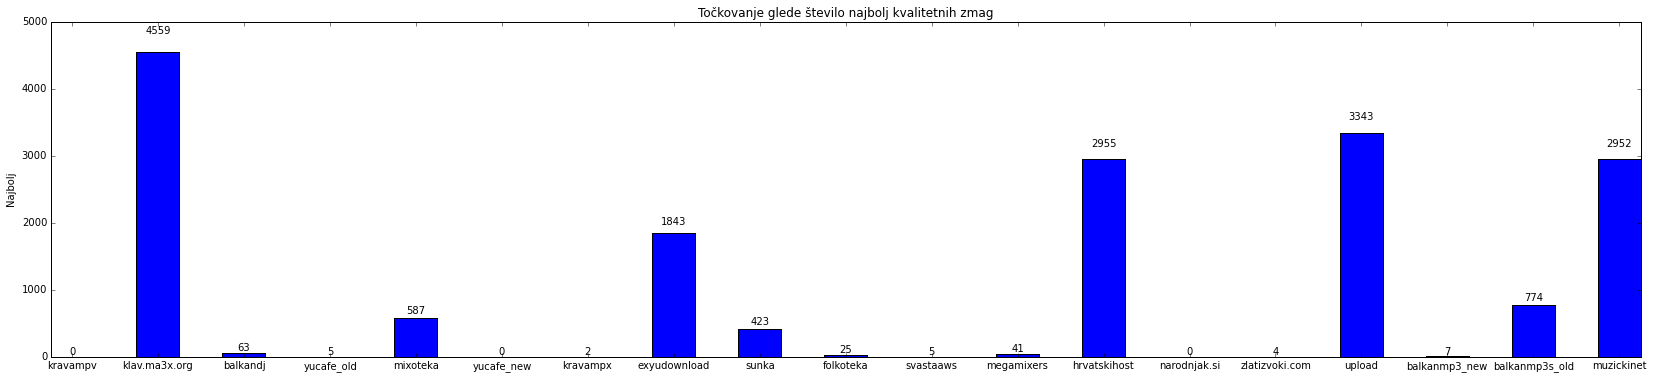

In [5]:
fig, ax = plt.subplots()

ax.set_xticks(np.arange(len(servers)) + width/2)
ax.set_xticklabels(list(server_dict[s] for s in server_ids))

ax.set_ylabel('Najbolj')
ax.set_title('Točkovanje glede število najbolj kvalitetnih zmag')

for rect in ax.bar(range(len(servers)), [servers[k].first_place for k in servers], color="blue", width=width):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '{0}'.format(height),
                ha="center", va="bottom")